# Testing the environment
---
## Setup

In [1]:
from rl4caribou import CaribouScipy
import numpy as np

In [2]:
env = CaribouScipy()

## Testing Wolf-Moose equilibrium

In [3]:
# set environment randomness to zero
env.parameters['sigma_M'], env.parameters['sigma_B'], env.parameters['sigma_W'] = 0, 0, 0 

In [4]:
T = 800
obs, info = env.reset()
M, B, W, LF = env.bound * (obs + 1) /2 
Ms, Bs, Ws, LFs = [M], [B], [W], [LF]
for t in range(T):
    obs, reward, terminated, truncated, info = env.step(np.array([-1, -1, -1]))
    M, B, W, LF = env.bound * (obs + 1) /2 
    Ms.append(M)
    Bs.append(B)
    Ws.append(W)
    LFs.append(LF)
    


In [5]:
import pandas as pd

simulation = pd.DataFrame(
    {
        't': [t for t in range(T+1)],
        'M': Ms,
        'B': Bs,
        'W': Ws,
    }
)

<Axes: xlabel='t'>

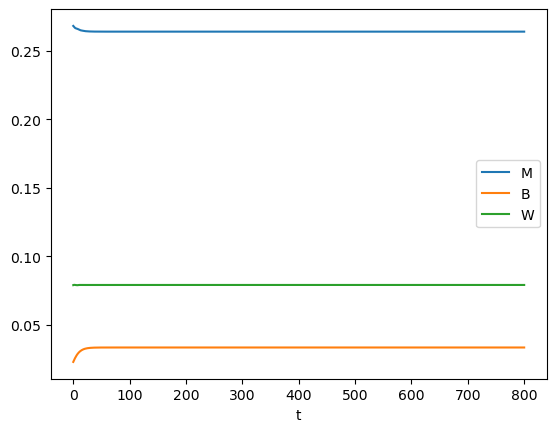

In [6]:
simulation.plot(x='t')

In [7]:
Ms[-1], Bs[-1], Ws[-1] # the -1 in this space is the last one (like the tail function in R)

(0.26403737, 0.03356117, 0.07919109)

## Ok we start from Moose-Wolf fixed point now

In [8]:
env.initial_pop = np.array([0.2711187, 0.0001, 0.07967687])

## We start managing

In [9]:
from rl4caribou.agents import constAction

In [10]:
pacifist = constAction(mortality_vec=np.array([0,0,0]))

In [11]:
def simulate(env, agent):
    T = 800
    obs, info = env.reset()
    M, B, W, LF = env.bound * (obs + 1) /2 
    LF = LF/env.bound
    Ms, Bs, Ws, LFs = [M], [B], [W], [LF]
    for t in range(T):
        action, info = agent.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        M, B, W, LF  = env.bound * (obs + 1) /2 
        LF = LF/env.bound
        Ms.append(M)
        Bs.append(B)
        Ws.append(W)
        LFs.append(LF)
    return pd.DataFrame(
        {
            't': [t for t in range(T+1)],
            'M': Ms,
            'B': Bs,
            'W': Ws,
            'LF': LFs
        }
    )

In [12]:
df = simulate(
    CaribouScipy(
        config={'initial_pop': np.array([0.2711187, 0.00001, 0.07967687])}
    ), 
    pacifist
)

<Axes: xlabel='t'>

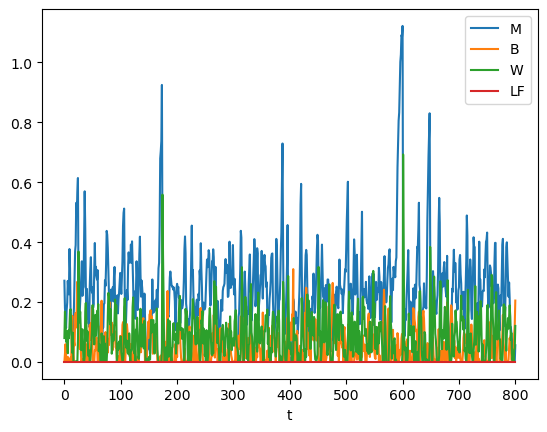

In [13]:
df.plot(x='t')

In [14]:
from stable_baselines3 import PPO # stable_baselines3 is the package with the algorithms

ppoAgent = PPO.load("../saved_agents/PPO-CaribouScipy-LFupdate.zip") 


/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


In [15]:
simulate(env, ppoAgent)

,t,M,B,W,LF
0,0,0.270925,0.000100,0.079823,0.000000
1,1,0.221526,0.000116,0.066991,0.000000
2,2,0.205453,0.000138,0.046713,0.000691
3,3,0.202614,0.000165,0.024385,0.000691
4,4,0.219136,0.000197,0.016865,0.000691
...,...,...,...,...,...
796,796,0.309554,0.046103,0.045723,0.308729
797,797,0.312208,0.045877,0.058840,0.308729
798,798,0.314413,0.044487,0.076996,0.308729
799,799,0.297448,0.042226,0.095123,0.308729


In [16]:
df = simulate(
    CaribouScipy(
        config={
            'initial_pop': np.array([0.2711187, 0.0001, 0.07967687]),
            'Tmax': 800,
        }
    ), 
    ppoAgent
)



<Axes: xlabel='t'>

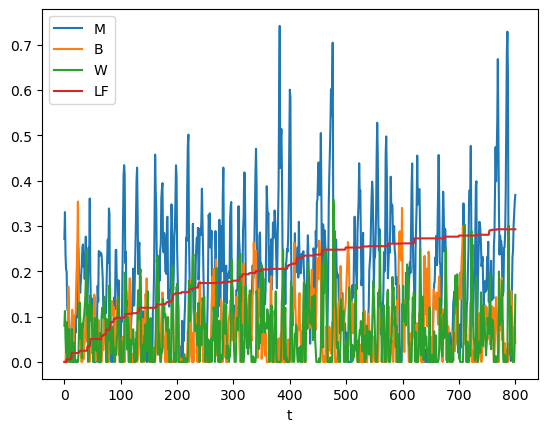

In [17]:
df.plot(x='t')

In [18]:
def simulate2(env, agent):
    T = env.Tmax
    print(T)
    obs, info = env.reset()
    M, B, W, LF = env.bound * (obs + 1) /2 
    LF = LF/env.bound
    Ms, Bs, Ws, LFs, moosecull, wolfcull  = [M], [B], [W], [LF], [0], [0]# the initial state there is no action yet #moosecull, wolfcull
    rewards = [0]
    for t in range(T):
        action, info = agent.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        M, B, W, LF = env.bound * (obs + 1) /2 
        LF = LF/env.bound
        Ms.append(M)
        Bs.append(B)
        Ws.append(W)
        LFs.append(LF)
        moosecull.append((action[0]+1)/2)
        wolfcull.append((action[1]+1)/2)
        rewards.append(reward)
        if terminated or truncated:
            break
        
    return pd.DataFrame(
        {
            't': [t for t in range(T+1)],
            'M': Ms,
            'B': Bs,
            'W': Ws,
            "LF": LFs,
            'moosecull': moosecull,
            'wolfcull': wolfcull,
            'reward': rewards
        }
    )


In [19]:
sim_df = simulate2(
    CaribouScipy(
        config={
            'initial_pop': np.array([0.2711187, 0.0001, 0.07967687]),
            'Tmax': 800,
        }
    ), 
    ppoAgent
)
sim_df['w_cull_avg'] =  sim_df.wolfcull.rolling(window=10).mean()
sim_df['m_cull_avg'] =  sim_df.moosecull.rolling(window=10).mean()

800


<Axes: xlabel='t'>

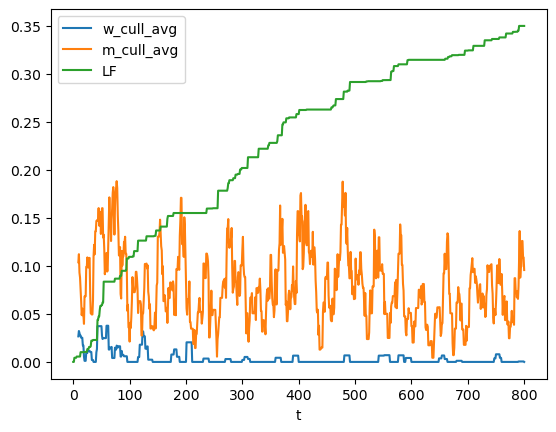

In [20]:
sim_df.plot(x='t', y = ['w_cull_avg', 'm_cull_avg', 'LF'])

-475.37868074782347


<Axes: xlabel='t'>

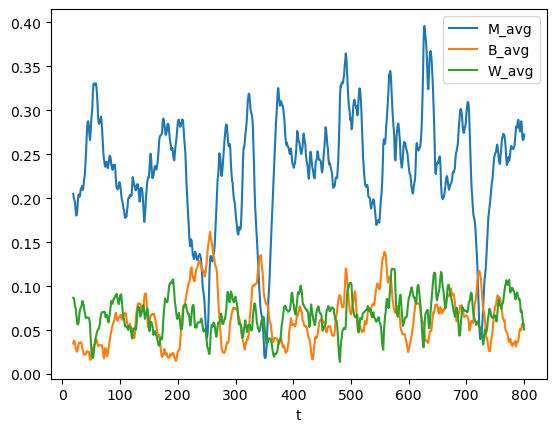

In [21]:
sim_df['M_avg'] =  sim_df.M.rolling(window=20).mean()
sim_df['B_avg'] =  sim_df.B.rolling(window=20).mean()
sim_df['W_avg'] =  sim_df.W.rolling(window=20).mean()

print(sim_df.reward.sum())
sim_df.plot(x='t', y=['M_avg', 'B_avg', 'W_avg'])

<Axes: xlabel='t'>

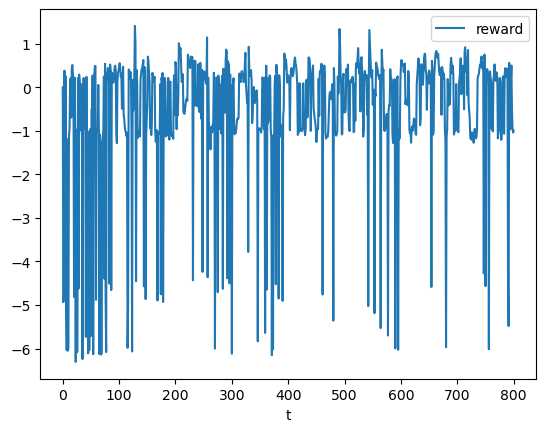

In [22]:
sim_df.plot(x='t', y='reward')

What's interesting is that no wolf culls are enacted, but the wolf populations are kept tamped down purely by lack of prey. this suggests in a limited trophic system (only prey for wolves are modeled), mooseculls would be enough to actually dampen wolf populations 

Now let's try a constant action instead of learning, and see how they compare 

In [23]:
constantmoosecull = constAction(mortality_vec=np.array([0.25019748630884014,0,0]))

In [24]:
const_df = simulate2(
    CaribouScipy(
        config={
            'initial_pop': np.array([0.2711187, 0.0001, 0.07967687]),
            'Tmax': 800,
        }
    ),
    constantmoosecull
)

const_df['M_avg'] =  const_df.M.rolling(window=20).mean()
const_df['B_avg'] =  const_df.B.rolling(window=20).mean()
const_df['W_avg'] =  const_df.W.rolling(window=20).mean()

800


-2033.1686129445889


<Axes: xlabel='t'>

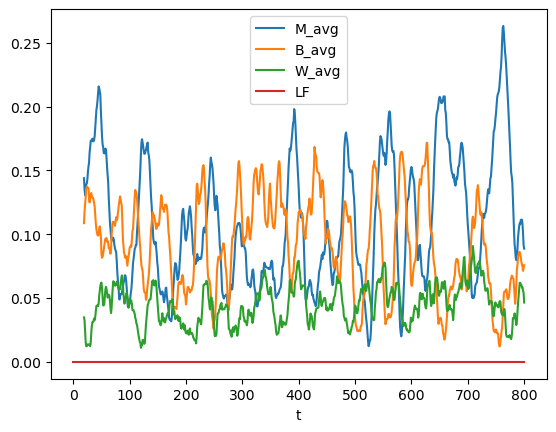

In [27]:
print(const_df.reward.sum())

const_df.plot(x='t', y=['M_avg', 'B_avg', 'W_avg', 'LF'])

<Axes: xlabel='t'>

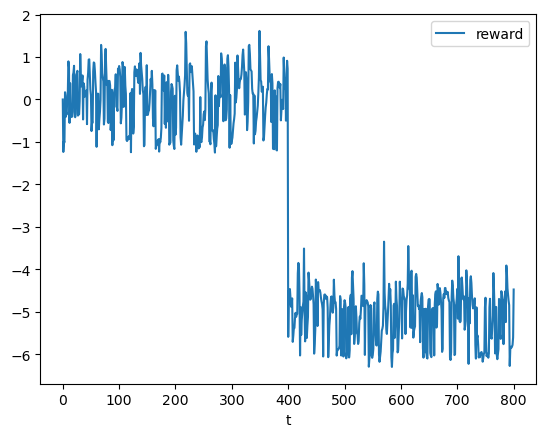

In [26]:
const_df.plot(x='t', y='reward')

everything is a lower equilibrium value that with the dynamic learning algorithm, especially caribou

In [28]:
constantwolf = constAction(mortality_vec=np.array([0,0.25019748630884014,0]))

In [29]:
df4 = simulate2(
    CaribouScipy(
        config={'initial_pop': np.array([0.2711187, 0.00001, 0.07967687])}
    ), 
    constantwolf
)

<Axes: xlabel='t'>

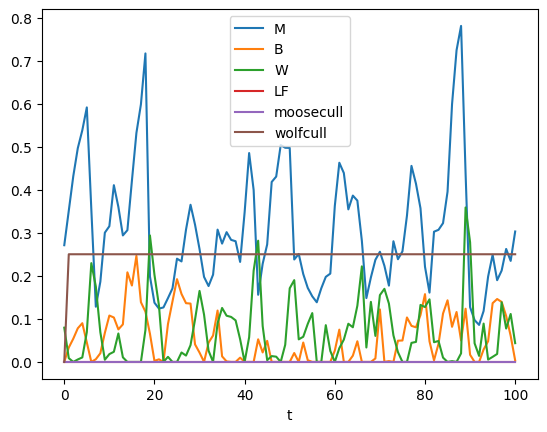

In [30]:
df4.plot(x='t')

In [31]:
df4

,t,M,B,W,LF,moosecull,wolfcull
0,0,0.271201,0.000010,0.079591,0.0,0.0,0.000000
1,1,0.351378,0.033370,0.008690,0.0,0.0,0.250197
2,2,0.431723,0.054020,0.000000,0.0,0.0,0.250197
3,3,0.496708,0.078125,0.005691,0.0,0.0,0.250197
4,4,0.538283,0.090014,0.010451,0.0,0.0,0.250197
...,...,...,...,...,...,...,...
96,96,0.189910,0.146163,0.018477,0.0,0.0,0.250197
97,97,0.212290,0.139440,0.138552,0.0,0.0,0.250197
98,98,0.262533,0.106782,0.077561,0.0,0.0,0.250197
99,99,0.234766,0.060630,0.111427,0.0,0.0,0.250197


In [32]:
merged = pd.DataFrame(
        {
            't': df2['t'],
            'dynammoose': df2['B'],
            'constmoose': df3['B'],
            'constwolf': df4['B']
        }
)

<Axes: xlabel='t'>

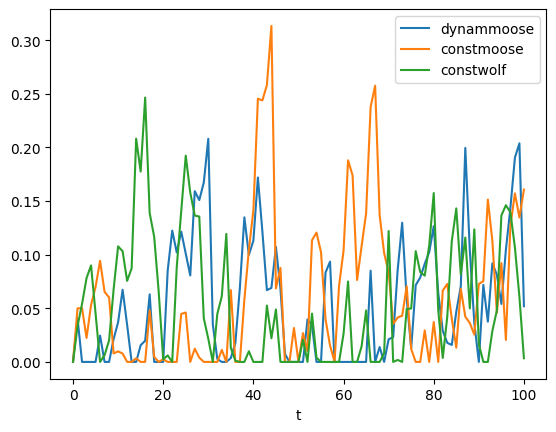

In [33]:
merged.plot(x='t')